In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle

In [123]:
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [124]:
positions = pd.read_csv('../data/povo-1/positions.csv')
predictions = pd.read_csv('../data/povo-1/predictions.csv')
targets = pd.read_csv('../data/povo-1/targets.csv')
A = '0001.png'
B = '0541.png'
C = '0999.png'

In [125]:
# corridoio lungo 127 px
#a = np.array([-0.149736, 0.425357, 0.667402])
#b = np.array([-0.80448, 0.492395, 0.14385])
# secondo tocco lungo 773px
px = 773
a = positions[positions.image == '0294.png'][['x','y','z']].squeeze()
b = positions[positions.image == '0774.png'][['x','y','z']].squeeze()
unit_measure = np.sqrt(np.sum((a - b)**2))
unit_measure

8.036762674545663

In [126]:
colmap_crs = positions[positions.image.isin([A, B, C])][['x','y','z']].values.T
cadatastral_crs = np.array([
    [1315, 850, 375],
    [100, 390, 150],
    [0, 0, 0]
])
colmap_crs = colmap_crs / unit_measure * px

In [127]:
# RA + t = B
R, t = rigid_transform_3D(colmap_crs, cadatastral_crs)
R, t

(array([[ 0.61735573,  0.18613352, -0.76434692],
        [-0.7847185 ,  0.07706359, -0.61504316],
        [-0.05557683,  0.97949758,  0.19363807]]),
 array([[8.76883585e+02],
        [3.56440437e+02],
        [1.80484741e-02]]))

In [128]:
#points = positions[positions.image.isin(['0554.png', '0001.png', '0999.png'])][['x','y','z']].values.T
points = positions[['x','y','z']].values.T
points = points / unit_measure * px

predictions = predictions[['tx','ty','tz']].values.T
predictions = predictions / unit_measure * px

targets = targets[['tx','ty','tz']].values.T
targets = targets / unit_measure * px

D = (np.matmul(R, points) + t).T
F = (np.matmul(R, predictions) + t).T
G = (np.matmul(R, targets) + t).T

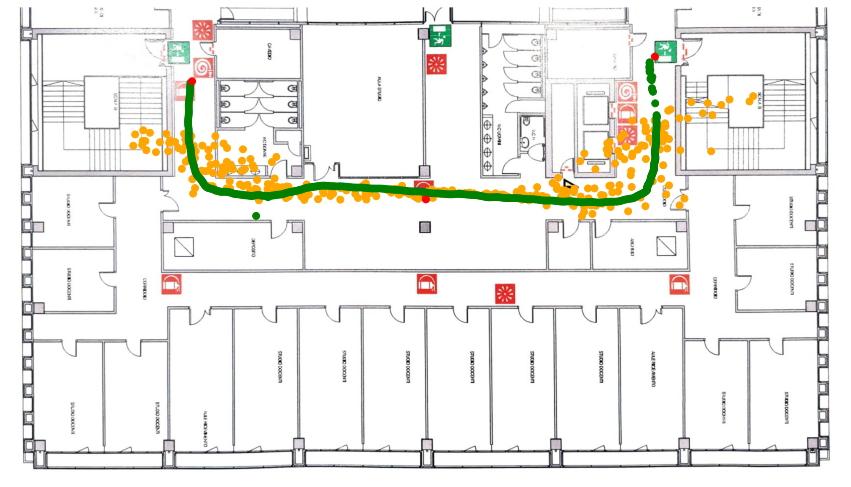

In [129]:
img = plt.imread('../camera-pose-estimation/models/posenet/static/cadatastral_plan.jpg')
fig, ax = plt.subplots(1, figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')

ax.imshow(img)
#for p in D: 
#    circ = Circle((p[0], p[1]), 7)
#    ax.add_patch(circ)
for p in F: 
    circ = Circle((p[0], p[1]), 7, color='orange')
    ax.add_patch(circ)
for p in G: 
    circ = Circle((p[0], p[1]), 7, color='green')
    ax.add_patch(circ)
for p in cadatastral_crs.T: 
    circ = Circle((p[0], p[1]), 7, color='red')
    ax.add_patch(circ)